# Creation of datasets for finetuning LLMs on arXiv abstracts

Useful info can be found here: https://info.arxiv.org/help/arxiv_identifier_for_services.html

# Outline

- [ 1 - Packages and setup](#1)
    - [1.1 - Log into huggingface hub](#1.1)
    - [1.2 - Define variables to automate extraction and upload](#1.2)
- [ 2 - Load full arXiv metadata (currently ~4.2Gb)](#2)
- [ 3 - Data manipulation](#3)
    - [3.1 - Identify small set of papers which we authored](#3.1)
    - [3.2 - Explore categories](#3.2)
    - [3.3 - Extract specific category/categories](#3.3)
    - [3.4 - Remove papers that have been withdrawn](#3.4)
- [ 4 - Look at the abstracts](#4)    
    - [4.1 - Length of abstracts](#4.1)
    - [4.2 - Keywords/PACS at end of abstracts](#4.2)
    - [4.3 - Multi-lingual abstracts](#4.3)
    - [4.4 - Look at distribution of dates from `id` column](#4.4)
- [ 5 - Clean the abstract data](#5)
- [ 6 - Convert to Huggingface dataset and push](#6)
    - [ 6.1 - Convert Pandas DataFrame to dataset Dataset](#6.1)
    - [ 6.2 - Split dataset into train, test and validation datasets](#6.2)
    - [ 6.3 - Upload data to Huggingface](#6.3)
- [ 7 - Concatenate hep-th_primary and hep-ph_gr-qc_primary datasets](#7)

<a name="1"></a>
## 1 - Packages and setup

In [1]:
import numpy as np 
import pandas as pd
import json
import re

import huggingface_hub
import datasets

<a name="1.1"></a>
### 1.1 - Log into huggingface hub

In [2]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("HFapi")
    huggingface_hub.login(secret_value_0)
except:
    huggingface_hub.login()

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


<a name="1.2"></a>
### 1.2 - Define variables to automate extraction and upload

In this subsection we define several variables which control how this notebook operates. Once these variables are set you can click `Run All`.

The variables are
1. `repo_id`: String. This is the name of the Huggingface repository that the dataset will be upload to. If the repository does not already exist it will be created.
2. `commit_message`: String or None. An optional commit message used in the `push_to_hub` function. Set it to `None` for an initial commit.
3. `wanted_categories`: List. A list of strings corresponding to arXiv categories. The code looks at the string data in the `categories` column and checks if any of the entries in `wanted_categories` appears.
4. `primary_classification_only`: Boolean. 
    * `True` will only match entries in `wanted_categories` to the first substring which appears in the `categories` column. 
    * `False` will match entries in `wanted_categories` if they appear *anywhere* in the `categories` column.
5. `train_size`: Float. Represents a percentage of data to use in creating a training dataset. `(1-train_size)` is used as a non-train dataset *i.e.* combined test and validation set.
6. `validation_size`: Float. Represents a percentage of data from the non-train dataset to use as a validation dataset. The remaining percentage, `(1-validation_size)`, is used as a test dataset. The test set is to be used for hyperparameter tuning etc with the validation set left unused until the end to determine final model performance.

In [3]:
repo_id = "LLMsForHepth/hep-th_primary"
commit_message = None # None will use default in `push_to_hub` which is `"Upload dataset"`

wanted_categories = ['hep-th'] 
primary_classification_only = True

train_size = 0.7 # use 70% of the dataset for training, 30% for testing & validation
validation_size = 0.5 # test_size is 1 - validation_size

<a name="2"></a>
## 2 - Load full arXiv metadata (currently ~4.2Gb)

The Kaggle dataset is described here: https://www.kaggle.com/datasets/Cornell-University/arxiv

In this notebook we've pinned the dataset to be v193 which includes submissions upto around 22nd August 2024.


Arxiv submissions are tightly controlled and should follow the instructions given here https://info.arxiv.org/help/prep.html.

In particular, the Title and Abstract metadata must be in ASCII input and Unicode characters should be converted to LaTex equivalent.
Since ASCII is a subset of utf-8 we can use utf-8 encoding to parse the json file.

In [4]:
df_dir='/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json'
json_data = []

with open(df_dir, 'r', encoding='utf-8') as f:
    for line in f:
        # Parse JSON from each line
        try:
            json_object = json.loads(line)
            json_data.append(json_object)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            continue
            
df = pd.DataFrame(json_data)
del json_data

<a name="3"></a>
## 3 - Data manipulation

In [5]:
df.shape

(2542615, 14)

In [6]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


<a name="3.1"></a>
### 3.1 - Identify small set of papers which we authored

We want to create a very small control dataset so we can see how well a LLM completes abstracts as it is being finetuned.

We choose the id of the paper which appears as the $n$th entry in each of our inspires record (Sid not included as no hep-th papers)
with $n = \text{entry number of citeable papers} \, // \, 2$.

In [7]:
ids = ["1804.08625", "1404.0016", "1205.2086", "1209.5915", "1802.05268"]
df_overfit = df[df['id'].isin(ids)]
df_overfit

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
341087,1205.2086,Vasilis Niarchos,Vasilis Niarchos,Seiberg dualities and the 3d/4d connection,"harvmac, 17 pages",None,10.1007/JHEP07(2012)075,CCTP-2012-07,hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We discuss the degeneration limits of d=4 su...,"[{'version': 'v1', 'created': 'Wed, 9 May 2012...",2015-06-05,"[[Niarchos, Vasilis, ]]"
373079,1209.5915,Michal P. Heller,"Jan de Boer, Borun D. Chowdhury, Michal P. Hel...",Towards a holographic realization of the quark...,"31 pages, 16 figures; v2: inset plot in Fig. 1...","Phys. Rev. D 87, 066009 (2013)",10.1103/PhysRevD.87.066009,None,hep-th hep-ph nucl-th,http://arxiv.org/licenses/nonexclusive-distrib...,Large-N_c QCD matter at intermediate baryon ...,"[{'version': 'v1', 'created': 'Wed, 26 Sep 201...",2013-03-28,"[[de Boer, Jan, ], [Chowdhury, Borun D., ], [H..."
513069,1404.0016,Constantinos Papageorgakis,Constantinos Papageorgakis and Andrew B. Royston,Revisiting Soliton Contributions to Perturbati...,"Latex, 25 pages; v2: Clarifications added and ...",None,10.1007/JHEP09(2014)128,"RUNHETC-2014-03, QMUL-PH-14-06, MIFPA-14-09",hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,It is often said that soliton contributions ...,"[{'version': 'v1', 'created': 'Mon, 31 Mar 201...",2020-08-04,"[[Papageorgakis, Constantinos, ], [Royston, An..."
944808,1802.05268,Jaewon Song,"Prarit Agarwal, Kazunobu Maruyoshi, Jaewon Song","A ""Lagrangian"" for the E7 Superconformal Theory","13 pages + appendices, v2: typos corrected",None,10.1007/JHEP05(2018)193,"SNUTP18-001, KIAS-P18021",hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We find an N=1 gauge theory that flows to th...,"[{'version': 'v1', 'created': 'Wed, 14 Feb 201...",2018-07-04,"[[Agarwal, Prarit, ], [Maruyoshi, Kazunobu, ],..."
970318,1804.08625,Pietro Benetti Genolini,"Pietro Benetti Genolini, Paul Richmond, James ...",Gravitational free energy in topological AdS/CFT,"46 pages; v2: corrected typos, updated references",JHEP 1809 (2018) 100,10.1007/JHEP09(2018)100,None,hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We define and study a holographic dual to th...,"[{'version': 'v1', 'created': 'Mon, 23 Apr 201...",2018-09-21,"[[Genolini, Pietro Benetti, ], [Richmond, Paul..."


In [8]:
# remove our papers from main dataframe so we don't double count
df = df[~df['id'].isin(ids)]

<a name="3.2"></a>
### 3.2 - Explore categories

See https://arxiv.org/category_taxonomy for a desciption of the values which can appear.
Each arXiv article has a primary category and may also have one or more cross-lists to other categories.

Inspecting `df.head()` we see that `df.iloc[1]['categories'] = 'math.CO cs.CG'`. The *primary* classifcation is `math.CO` and it is also cross-listed to the `cs.BG` category.

In [9]:
# there are many combinations of primary and cross-list categories
df['categories'].value_counts()

categories
astro-ph                                                            86911
hep-ph                                                              81611
quant-ph                                                            70092
cs.CV                                                               60946
hep-th                                                              59147
                                                                    ...  
physics.hist-ph astro-ph.IM eess.SP                                     1
physics.plasm-ph cond-mat.mtrl-sci cond-mat.soft physics.flu-dyn        1
cs.NA cs.NE physics.comp-ph                                             1
physics.soc-ph nucl-ex physics.ins-det                                  1
supr-con cond-mat.supr-con quant-ph                                     1
Name: count, Length: 84868, dtype: int64

In [10]:
# split string appearing in `categories` on white space and expand
# split_cats[0] is the *primary* classification
split_cats = df['categories'].str.split(n=-1, expand=True)
primary_cat = split_cats[0]

In [11]:
# get a list of primary classifications and associated count
# list is ordered in descending count  
primary_cats_and_counts = list(zip(split_cats[0].value_counts().keys().tolist(), split_cats[0].value_counts().tolist()))
primary_cats_and_counts

[('hep-ph', 132678),
 ('quant-ph', 109916),
 ('hep-th', 105617),
 ('cs.CV', 99967),
 ('astro-ph', 94246),
 ('cs.LG', 87968),
 ('gr-qc', 63776),
 ('cond-mat.mes-hall', 63246),
 ('cond-mat.mtrl-sci', 60664),
 ('cs.CL', 51717),
 ('math.AP', 48821),
 ('cond-mat.str-el', 47924),
 ('astro-ph.GA', 46346),
 ('math.CO', 45184),
 ('astro-ph.SR', 43046),
 ('cond-mat.stat-mech', 40585),
 ('astro-ph.CO', 40024),
 ('astro-ph.HE', 39238),
 ('math.PR', 38798),
 ('math.AG', 35704),
 ('cs.IT', 35461),
 ('nucl-th', 33374),
 ('math.NT', 32267),
 ('math-ph', 31717),
 ('math.OC', 31480),
 ('cond-mat.supr-con', 31443),
 ('physics.optics', 29206),
 ('math.DG', 28872),
 ('math.NA', 28631),
 ('cond-mat.soft', 28076),
 ('cs.RO', 24310),
 ('hep-ex', 23111),
 ('math.DS', 22575),
 ('cs.CR', 22570),
 ('cs.AI', 22356),
 ('astro-ph.EP', 22309),
 ('math.FA', 19889),
 ('stat.ME', 19555),
 ('physics.flu-dyn', 19071),
 ('astro-ph.IM', 17963),
 ('hep-lat', 17952),
 ('stat.ML', 16779),
 ('eess.SP', 16132),
 ('cs.NI', 16004)

<a name="3.3"></a>
### 3.3 - Extract specific category/categories

**NB:** The variables `wanted_categories` and `primary_classification_only` are defined in section [1.2](#1.2)

In [12]:
if primary_classification_only:
    # we get those papers whose *primary* classification is in `wanted_categories`
    df = df[primary_cat.apply(lambda x: any(k in x for k in wanted_categories))]
else:
    # we get papers where `wanted_categories` appears anywhere in `categories` i.e. primary and also in cross-listing
    df = df[df['categories'].apply(lambda x: any(k in x for k in wanted_categories))]

In [13]:
df.shape

(105617, 14)

<a name="3.4"></a>
### 3.4 - Remove papers that have been withdrawn

See https://info.arxiv.org/help/withdraw.html

In [14]:
# make an index of comments which contain either 'Withdrawn' or 'withdrawn'
withdrawn = df['comments'].str.contains('Withdrawn', case=False) # empty comments return None
withdrawn.fillna(value=False, inplace=True) # replace None with False
withdrawn.value_counts()

/tmp/ipykernel_33/270111922.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  withdrawn.fillna(value=False, inplace=True) # replace None with False


comments
False    105399
True        218
Name: count, dtype: int64

In [15]:
# sanity check but takes a while
# make an index of abstracts which contain either 'Withdrawn' or 'withdrawn'
# this way is quicker than using contains('withdrawn', case=False)
withdrawn_abs = df['abstract'].str.contains('Withdrawn') | df['abstract'].str.contains('withdrawn') #| df['abstract'].str.contains('removed') 
withdrawn_abs.value_counts()

abstract
False    105496
True        121
Name: count, dtype: int64

In [16]:
# look at entries with `withdrawn` in abstract but not in comments
df[~withdrawn & withdrawn_abs]

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
71809,0807.0816,Patricio Gaete,Patricio Gaete and Iv\'an Schmidt,Confinement effects from massive photons,4 pages,None,None,USM-TH-235,hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,This paper has been withdrawn by the author ...,"[{'version': 'v1', 'created': 'Fri, 4 Jul 2008...",2010-04-12,"[[Gaete, Patricio, ], [Schmidt, Iván, ]]"
2381575,hep-th/0001079,Valerie Nowak,Stephen L. Adler,Lifshitz Phase Gauge Symmetry Breaking and App...,Withdrawal,None,None,IASSNS-HEP-00/04,hep-th,None,"This paper has been withdrawn, because the a...","[{'version': 'v1', 'created': 'Wed, 12 Jan 200...",2007-05-23,"[[Adler, Stephen L., ]]"
2383274,hep-th/0007251,Klaus Kirsten,Klaus Kirsten,Spectral functions in mathematics and physics,"225 pages, LaTeX",None,None,"Habilitationsschrift May 1999, Universitaet Le...",hep-th,None,This manuscript has been withdrawn by the au...,"[{'version': 'v1', 'created': 'Mon, 31 Jul 200...",2007-05-23,"[[Kirsten, Klaus, ]]"
2386358,hep-th/0107129,Chehyon Shio,C. Shio,Polarization Effects on Fermion Mass,Withdrawing this paper due to crucial errors i...,None,None,HLP-703,hep-th,None,Due to unsuitable attempt to connect the bas...,"[{'version': 'v1', 'created': 'Sun, 15 Jul 200...",2007-05-23,"[[Shio, C., ]]"
2387437,hep-th/0111170,Tom Banks,"T. Banks, W. Fischler",Black Crunch,"JHEP LaTeX, 9 pages",None,None,"RUNHETC-2001-33, SCIPP-01/25, UTTG-20-01",hep-th,None,This paper has been withdrawn.\n,"[{'version': 'v1', 'created': 'Tue, 20 Nov 200...",2007-05-23,"[[Banks, T., ], [Fischler, W., ]]"
2387481,hep-th/0111214,Antonio F. Ranada,"Antonio F. Ranada (Universidad Complutense, Ma...",A topological formulation of the Planck-Einste...,"18 pages, no figures Reason of replacement: th...",None,None,None,hep-th quant-ph,None,The paper has been withdrawn\n,"[{'version': 'v1', 'created': 'Fri, 23 Nov 200...",2007-05-23,"[[Ranada, Antonio F., , Universidad Complutens..."
2387683,hep-th/0112124,Tomohiko Takahashi,"Tomohiko Takahashi, Seriko Tanimoto",Dilaton Condensation in Cubic Open String Fiel...,None,None,None,None,hep-th,None,This paper has been withdrawn by the authors...,"[{'version': 'v1', 'created': 'Fri, 14 Dec 200...",2007-05-23,"[[Takahashi, Tomohiko, ], [Tanimoto, Seriko, ]]"
2390224,hep-th/0210021,Nejat Tevfik Yilmaz,N.T.Yilmaz,The Projection Conditions and Discrete Torsion...,12 pages,None,None,None,hep-th,None,This work has been withdrawn.\n,"[{'version': 'v1', 'created': 'Thu, 3 Oct 2002...",2007-05-23,"[[Yilmaz, N. T., ]]"
2390771,hep-th/0211255,Sviatoslav Solganik,S. Solganik,Rolling Tachyon and Fields on the Brane,None,None,None,None,hep-th,None,This paper has been withdrawn by the author.\n,"[{'version': 'v1', 'created': 'Tue, 26 Nov 200...",2007-05-23,"[[Solganik, S., ]]"
2396911,hep-th/0410036,Kelly Davis,Kelly C. Davis,Holography and Quantum Gravity in 3+1 Dimensions,"71 pages and 4 figures. Uses JHEP style, xy-pi...",None,None,AEI-2004-076,hep-th gr-qc,None,"This paper has been withdrawn by the author,...","[{'version': 'v1', 'created': 'Tue, 5 Oct 2004...",2007-05-23,"[[Davis, Kelly C., ]]"


In [17]:
# drop the withdrawn papers
df = df[~(withdrawn | withdrawn_abs)]
df.shape

(105384, 14)

<a name="4"></a>
## 4 - Look at the abstracts

<a name="4.1"></a>
### 4.1 - Length of abstracts

In [18]:
df.reset_index(drop=True, inplace=True)

In [19]:
# get the number of characters in each abstract
abstract_len = df['abstract'].map(lambda x: len(x))
# look at the summary statistics for abstract_len
abstract_len.describe()
# According to https://info.arxiv.org/help/prep.html
# abstracts longer than 1920 characters are not accepted. 
# So when did this rule begin as we have examples of abstract_len > 1920?

count    105384.000000
mean        762.322127
std         353.951587
min          21.000000
25%         501.000000
50%         710.000000
75%         972.000000
max        2114.000000
Name: abstract, dtype: float64

<Axes: >

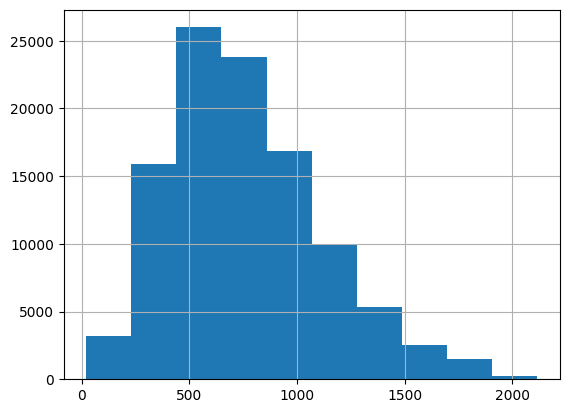

In [20]:
abstract_len.hist()

In [21]:
# Take a look at the longest abstract
df.iloc[abstract_len.idxmax()]['abstract']

"  This work explores the role of thermodynamic fluctuations in the two\nparameter Hawking radiating black hole configurations. The system is\ncharacterized by an ensemble of arbitrary mass and radiation frequency of the\nblack holes. In the due course of the Hawking radiations, we find that the\nintrinsic geometric description exhibits an intriguing set of exact pair\ncorrection functions and global correlation lengths. We investigate the nature\nof the constant amplitude radiation and find that it's not stable under\nfluctuations of the mass and frequency. Subsequently, the consideration of the\nYork model decreasing amplitude radiation demonstrates that thermodynamic\nfluctuations are globally stable in the small frequency region. In connection\nwith quantum gravity refinements, we take an account of the logarithmic\ncorrection into the constant amplitude and York amplitude over the Hawking\nradiation. In both considerations, we notice that the nature of the possible\nparametric flu

Things to notice about the above abstract
- there is lots of whitespace at the start
- there are many \n instead of spaces

This suggests we replace \n with ' ' and strip out the extra leading/trailing whitespaces.

<a name="4.2"></a>
### 4.2 - Keywords/PACS at end of abstracts

In [22]:
# Turns out there's PACS numbers and Keywords at the end of some abstracts,
# should we remove these for training a LLM?
# Find which abstracts contain either 'Keyword' or 'PACS'
has_keyword = df['abstract'].str.contains('Keyword|PACS', case=False)
df[has_keyword].shape[0]

67

In [23]:
# df[has_keyword].iloc[0]['abstract']

In [24]:
print(f"Percentage of abstacts with Keywords or PACS is {100 * df[has_keyword].shape[0] / df.shape[0]:.3f}%")

Percentage of abstacts with Keywords or PACS is 0.064%


<a name="4.3"></a>
### 4.3 - Multi-lingual abstracts

See https://info.arxiv.org/help/faq/multilang.html

First we find any multi-lingual abstracts

In [25]:
multi = df['abstract'].str.contains("-----")
multi.value_counts()

abstract
False    105384
Name: count, dtype: int64

In [26]:
print(f"Percentage of multi-lingual abstacts is {100 * df[multi].shape[0] / df.shape[0]:.3f}%")

Percentage of multi-lingual abstacts is 0.000%


In [27]:
english_only = df['abstract'].apply(lambda x: x.split("-----")[0])

We have to be careful because there are some abstracts which have metric signatures denoted by $+-----$ as can be seen below!

In [28]:
# df[multi]['abstract'].iloc[3]

To remove the "-----" and everything after it we would use the following

In [29]:
english_only = df['abstract'].apply(lambda x: x.split("-----")[0])

However, since there are very few examples we leave things as they are

## 4.4 - Look at distribution of dates from `id` column

Old scheme identifiers are of the form hep-th/9901001.

New scheme identifiers are of the form 0704.0001 or 1501.00001

In [30]:
# The dataframes look to be ordered by identifier
df['id'][:-10]

0              0704.0015
1              0704.0018
2              0704.0052
3              0704.0064
4              0704.0066
               ...      
105369    hep-th/9912280
105370    hep-th/9912281
105371    hep-th/9912282
105372    hep-th/9912283
105373    hep-th/9912284
Name: id, Length: 105374, dtype: object

In [31]:
def get_year_from_id(id):
    if '.' in id:
        year = id[:2]
    else:
        tmp = id.split('/')[1]
        year = tmp[:2]
    if year[0] == '9':
        year = '19' + year
    else:
        year = '20' + year
    return year

In [32]:
years = df['id'].map(get_year_from_id)

<Axes: >

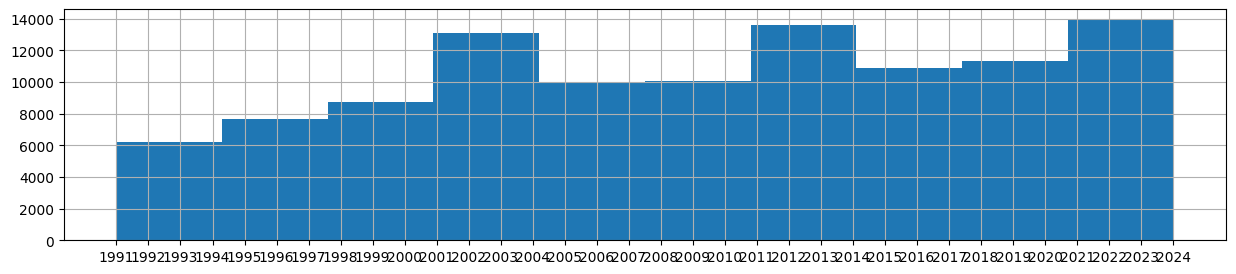

In [33]:
years.sort_values(ascending=True).hist(figsize=(15,3))

<a name="5"></a>
## 5 - Clean the abstract data

In [34]:
def clean_abstracts(abstract):
    abstract = re.sub(r'\n\s*', ' ', abstract)  # replace '\n' and any whitespace immediately after it with a single whitespace
    abstract = abstract.strip()  # remove leading/trailing whitespace
    return abstract

In [35]:
# apply `clean_abstracts` function to Series. Don't know how to do this inplace
# so we add a new column and then do some renaming
df['cleaned_abstract'] = df['abstract'].map(clean_abstracts)
df = df.rename(columns={"abstract": "orig_abstract", "cleaned_abstract": "abstract"})

In [36]:
df['abstract'].iloc[0]

'The pure spinor formulation of the ten-dimensional superstring leads to manifestly supersymmetric loop amplitudes, expressed as integrals in pure spinor superspace. This paper explores different methods to evaluate these integrals and then uses them to calculate the kinematic factors of the one-loop and two-loop massless four-point amplitudes involving two and four Ramond states.'

<a name="6"></a>
## 6 - Convert to Huggingface dataset and push

<a name="6.1"></a>
### 6.1 - Convert Pandas DataFrame to dataset Dataset

In [37]:
raw_dataset = datasets.Dataset.from_pandas(df, preserve_index=False)

<a name="6.2"></a>
### 6.2 - Split dataset into train, test and validation datasets

use `?datasets.Dataset.train_test_split` to get full documentation.

Since the DataFrame seems to be ordered by `id` column we must randomly shuffle before splitting.

**NB:** The variables `train_size` and `validation_size` are defined in section [1.2](#1.2)

In [38]:
train_testvalid = raw_dataset.train_test_split(train_size=train_size, seed=42, shuffle=True)
test_valid = train_testvalid['test'].train_test_split(test_size=validation_size, seed=42, shuffle=True)

train_test_valid_dataset = datasets.DatasetDict({'train': train_testvalid['train'],
                                                 'test': test_valid['test'],
                                                 'validation': test_valid['train']})

In [39]:
# print the number of entries in each dataset
for name, data in train_test_valid_dataset.items():
    print(f"Dataset {name} has size {data.shape[0]}")

Dataset train has size 73768
Dataset test has size 15808
Dataset validation has size 15808


<a name="6.3"></a>
### 6.3 - Upload data to Huggingface

See `?datasets.Dataset.push_to_hub` for full documentation.

**NB:** The variables `repo_id` and `commit_message` are defined in section [1.2](#1.2)

In [40]:
# Push the Dataset to Huggingface
try:
    train_test_valid_dataset.push_to_hub(repo_id, commit_message=commit_message)
except:
    huggingface_hub.create_repo(repo_id=repo_id,
                                repo_type="dataset",
                                private=True,
                                commit_message=commit_message)
    train_test_valid_dataset.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/74 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

In [82]:
# logout from Huggingface
huggingface_hub.logout()

Successfully logged out.


****NB: we can get previous instances of datasets by using****

```
ds_old = datasets.load_dataset('LLMsForHepth/arxiv_hepth_first', 
                               revision='346140be7a01f109af9845a0e3742b9fcd66fd9a')
                               ```
                               
where '346140be7a01f109af9845a0e3742b9fcd66fd9a' is a commit hash found on the repo website

In [2]:
ds = load_dataset('LLMsForHepth/hep-th_primary')

Generating train split:   0%|          | 0/73768 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15808 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15808 [00:00<?, ? examples/s]

<a name="7"></a>
## 7 - Concatenate hep-th_primary and hep-ph_gr-qc_primary datasets

In [5]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

In [6]:
ds_1 = load_dataset('LLMsForHepth/hep-th_primary')
ds_2 = load_dataset('LLMsForHepth/hep-ph_gr-qc_primary')

Generating train split:   0%|          | 0/73768 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/15808 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15808 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/137136 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/29387 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/29386 [00:00<?, ? examples/s]

In [12]:
ds_concat = DatasetDict()
names = ds_1.keys()

for name in names:
    ds_concat[name] = concatenate_datasets([ds_1[name], ds_2[name]])

In [13]:
ds_concat

DatasetDict({
    train: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'orig_abstract', 'versions', 'update_date', 'authors_parsed', 'abstract'],
        num_rows: 210904
    })
    test: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'orig_abstract', 'versions', 'update_date', 'authors_parsed', 'abstract'],
        num_rows: 45195
    })
    validation: Dataset({
        features: ['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi', 'report-no', 'categories', 'license', 'orig_abstract', 'versions', 'update_date', 'authors_parsed', 'abstract'],
        num_rows: 45194
    })
})

In [16]:
# Push the Dataset to Huggingface
try:
    ds_concat.push_to_hub('LLMsForHepth/hep-th_hep-ph_gr-qc_primary_v2')
except:
    huggingface_hub.create_repo(repo_id='LLMsForHepth/hep-th_hep-ph_gr-qc_primary_v2',
                                repo_type="dataset",
                                private=False)
    ds_concat.push_to_hub(repo_id)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/211 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/46 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/46 [00:00<?, ?ba/s]